In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils


2024-01-11 10:17:26.704602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 10:17:26.704667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 10:17:26.705430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 10:17:26.711094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 10:17:27.517284: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:40]}

In [7]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
ns_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)', 'Inclination (deg)', 'Latitude (deg)', 'Altitude (m)']


utils.set_random_seed(42)
# ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
#                                       label_features=['EW_Node_Location'], pad_location_labels=1,
#                                       train_val_split=0.95, stride=1, input_stride=1, padding=False,
#                                       transform_features=True,
#                                       input_history_steps=20, input_future_steps=20, seed=69)

ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
                                      label_features=['NS_Node_Location'], pad_location_labels=2,
                                      train_val_split=0.95, stride=1, input_stride=4, padding=False,
                                      transform_features=True,
                                      input_history_steps=80, input_future_steps=80, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 237 nVal: 13 (0.95)
Padding: False
Scaling: True
Horizons: 80-80 @ stride 4
Sin-Transformed features: []
Padding locations (2)
Labels: ['NS_Node_Location']
=========================Finished Dataset=========================


In [4]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True)

print(train_ew.element_spec)

# TODO: make localizer its one class, with proper binary output so that different metrics can be evaluated live
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=40, verbose=1, plot_hist=False, class_weight={0: 1.0, 1: 10.0}, callbacks=[])
model_ew.model.save('models/ew_localizer.hdf5')

model_ew.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ew.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

(TensorSpec(shape=(None, 40, 5), dtype=tf.float64, name=None), {'EW_Node_Location': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40, 5)]           0         
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)               

2024-01-10 23:33:10.858951: I external/local_xla/xla/service/service.cc:168] XLA service 0x8e3f790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 23:33:10.859011: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-10 23:33:10.864989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-10 23:33:11.452127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704925991.545103   60628 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


912/991 [==========================>...] - ETA: 1s - loss: nan - binary_accuracy: 0.9615

: 

In [9]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[[64,32],[32,8]], dense_layers=[128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 5.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40, 6)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 9, 64)             12352     
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 32)             16416     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080

KeyboardInterrupt: 

In [18]:
model_ns = tf.keras.models.load_model('/home/david/Code/splid-challenge/models/ns_localizer.hdf5')
#model_ew.save('models/ew_localizer.hdf5')



In [5]:
eval_df, evaluator, mergeDf = evaluation.evaluate_localizer(ds_gen_ns, split_dataframes=split_dataframes, gt_path=challenge_data_dir / 'train_labels.csv', model=model_ns.model, train=False, with_initial_node=False, remove_consecutives=True, direction='NS', return_scores=False)


3156/3156 - 10s - 10s/epoch - 3ms/step
    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        104        120         0              1   SS   NK        NS
1        104        132         0              1   SS   NK        NS
2        114        216         0              1   SS   NK        NS
3        114        227         0              1   SS   NK        NS
4        114        239         1              1   IK   HK        NS
5        114        252         0              1   IK   HK        NS
6        115        216         0              1   SS   NK        NS
7        115        227         0              1   SS   NK        NS
8        115        239         1              1   IK   HK        NS
9        115        252         0              1   IK   HK        NS
10       116        216         0              1   SS   NK        NS
11       116        227         0              1   SS   NK        NS
12       116        239         1              1   IK   HK      

In [40]:
print(eval_df.loc[(eval_df['ObjectID']==212)].head(20))

['200', '189', '213', '128', '2', '13', '27', '247', '159', '83', '133', '40', '41', '7', '129', '209', '55', '99', '196', '14', '49', '95', '56', '12', '37', '191', '181', '32', '188', '23', '109', '29', '154', '183', '43', '132', '158', '25', '62', '92', '6', '96', '35', '225', '117', '94', '250', '142', '194', '219', '162', '145', '38', '166', '39', '75', '113', '18', '3', '168', '134', '118', '80', '111', '243', '57', '242', '172', '140', '179', '231', '124', '192', '174', '81', '249', '68', '70', '146', '163', '206', '89', '31', '203', '149', '195', '103', '232', '182', '64', '152', '141', '207', '108', '125', '126', '101', '151', '77', '186', '110', '16', '226', '169', '79', '59', '17', '138', '72', '180', '1', '144', '178', '246', '127', '46', '244', '130', '106', '90', '34', '175', '102', '22', '164', '112', '190', '65', '136', '156', '228', '85', '234', '217', '93', '143', '53', '131', '173', '177', '147', '150', '204', '20', '216', '155', '42', '197', '201', '135', '24', '237

['200', '189', '213', '128', '2', '13', '27', '247', '159', '83', '133', '40', '41', '7', '129', '209', '55', '99', '196', '14', '49', '95', '56', '12', '37', '191', '181', '32', '188', '23', '109', '29', '154', '183', '43', '132', '158', '25', '62', '92', '6', '96', '35', '225', '117', '94', '250', '142', '194', '219', '162', '145', '38', '166', '39', '75', '113', '18', '3', '168', '134', '118', '80', '111', '243', '57', '242', '172', '140', '179', '231', '124', '192', '174', '81', '249', '68', '70', '146', '163', '206', '89', '31', '203', '149', '195', '103', '232', '182', '64', '152', '141', '207', '108', '125', '126', '101', '151', '77', '186', '110', '16', '226', '169', '79', '59', '17', '138', '72', '180', '1', '144', '178', '246', '127', '46', '244', '130', '106', '90', '34', '175', '102', '22', '164', '112', '190', '65', '136', '156', '228', '85', '234', '217', '93', '143', '53', '131', '173', '177', '147', '150', '204', '20', '216', '155', '42', '197', '201', '135', '24', '237

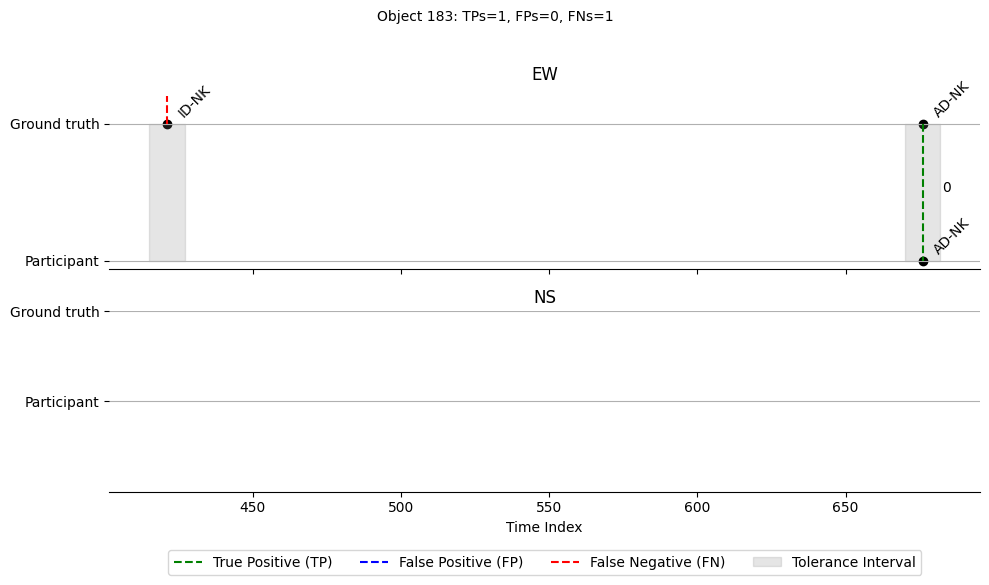

In [16]:
print(ds_gen_ew.train_keys)
evaluator.plot(183)

In [20]:

direction = 'EW'
ground_truth_from_file = pd.read_csv(labels_dir)
ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin([121,122,123])].copy()
ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]
ground_truth_from_file = ground_truth_from_file.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

mergeDf = ground_truth_from_file.copy()
mergeDf = mergeDf.drop([4])
mergeDf.loc[-1] = [121, 817, 'EW', 'IK', 'HK']  # adding a row
mergeDf.index = mergeDf.index + 1  # shifting index
mergeDf = mergeDf.sort_index()  # sorting by index
print(mergeDf)
print(ground_truth_from_file)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F2: {f2:.2f}')
print(f'RMSE: {rmse:.4}')
print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    ObjectID  TimeIndex Direction Node Type
0        121        817        EW   IK   HK
1        121          0        EW   SS   NK
2        121        124        EW   AD   NK
3        121        557        EW   AD   NK
4        121        783        EW   AD   NK
6        122          0        EW   SS   NK
7        122        124        EW   AD   NK
8        122        557        EW   AD   NK
9        122        783        EW   AD   NK
10       122        816        EW   IK   HK
11       123          0        EW   SS   NK
12       123        124        EW   AD   NK
13       123        557        EW   AD   NK
14       123       1804        EW   AD   NK
    ObjectID  TimeIndex Direction Node Type
0        121          0        EW   SS   NK
1        121        124        EW   AD   NK
2        121        557        EW   AD   NK
3        121        783        EW   AD   NK
4        121        816        EW   IK   HK
5        122          0        EW   SS   NK
6        122        124        E

In [ ]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

2024-01-06 23:47:48.838844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1028534400 exceeds 10% of free system memory.


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 